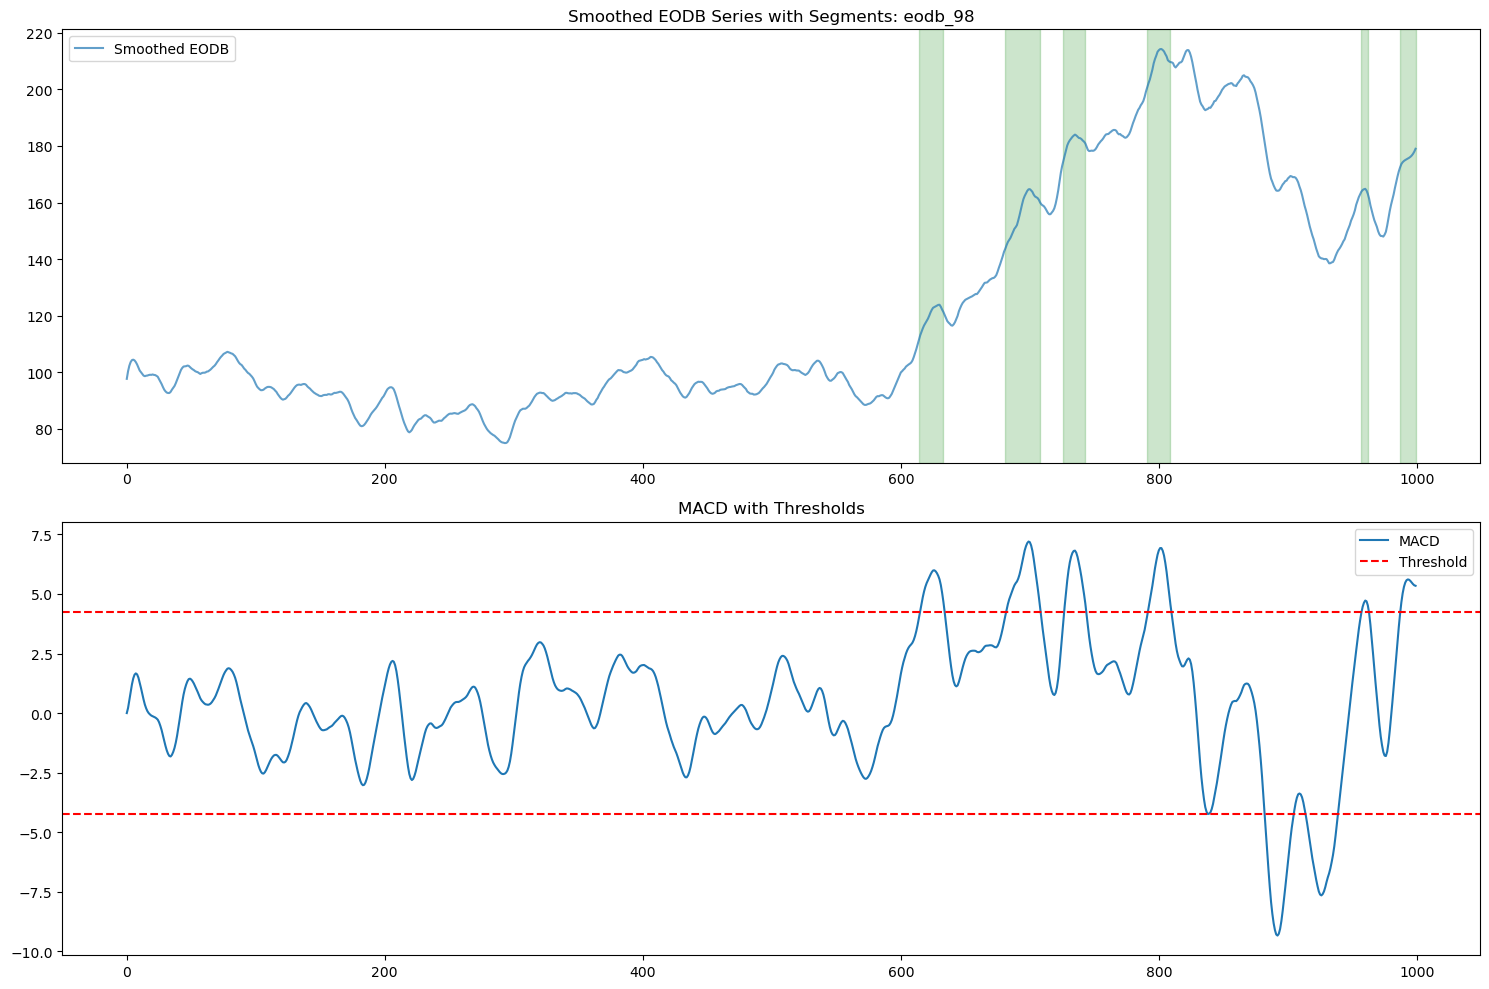

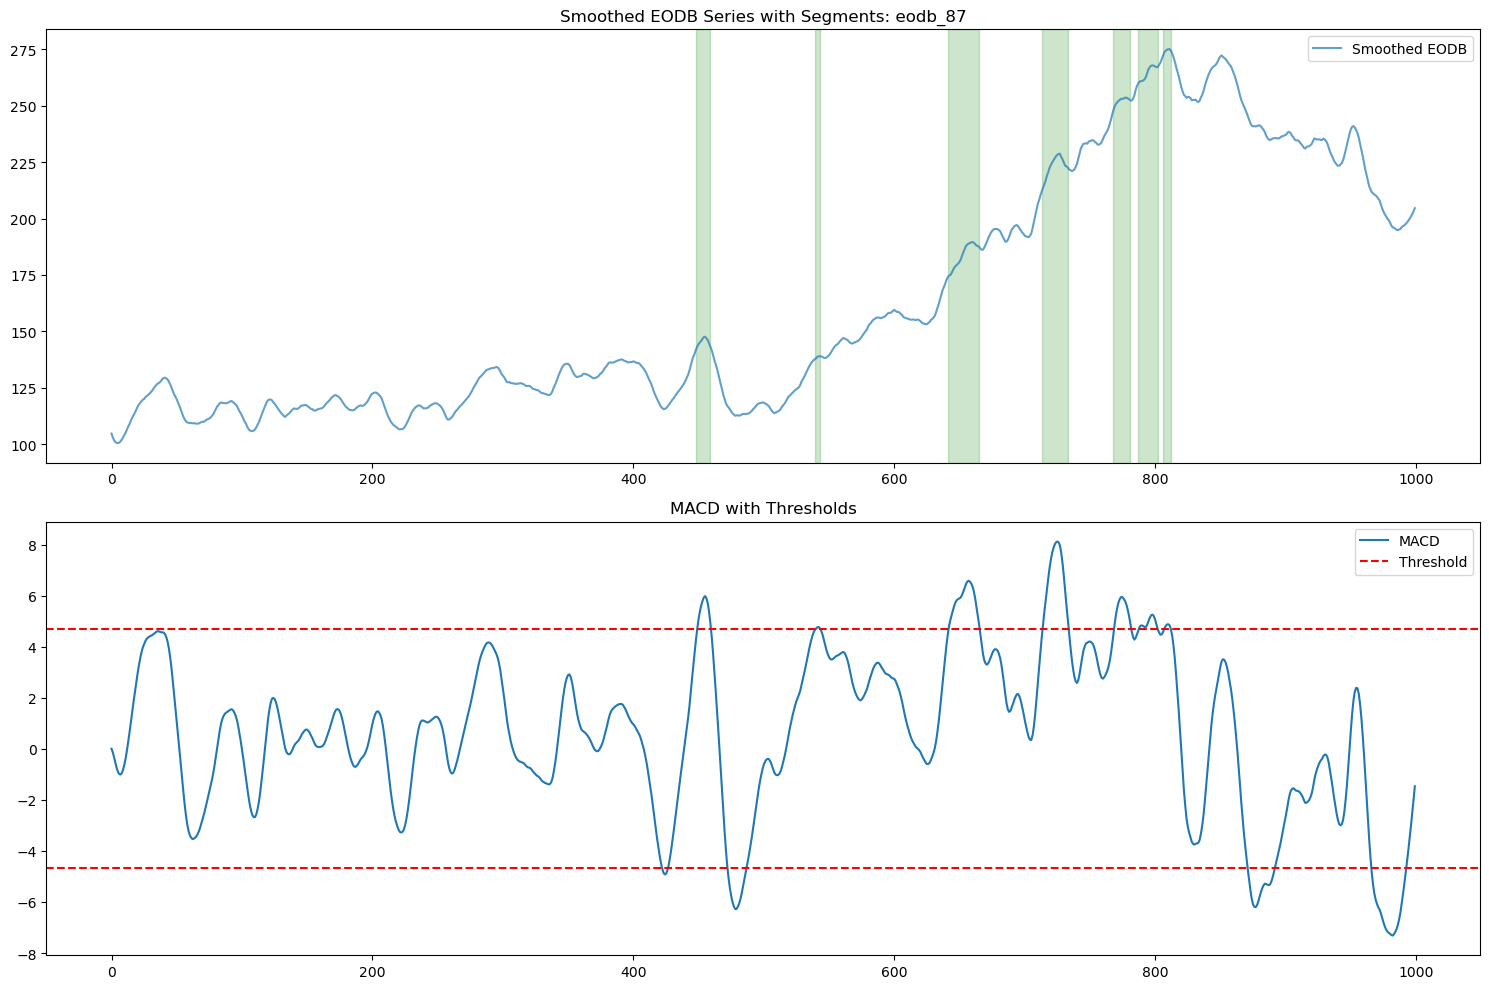

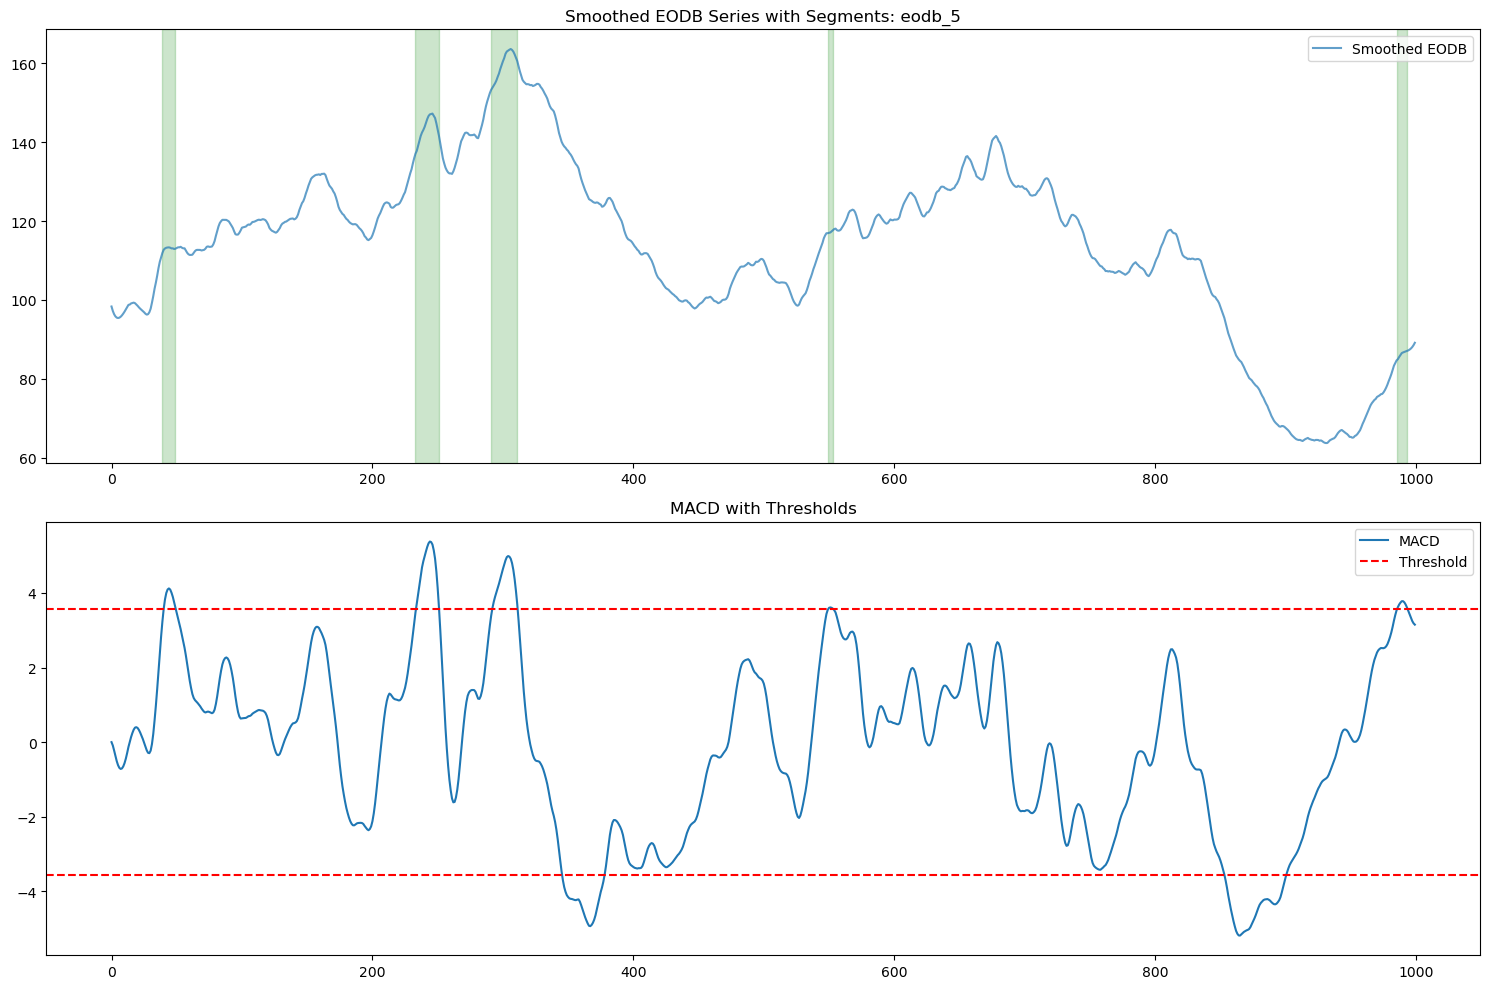

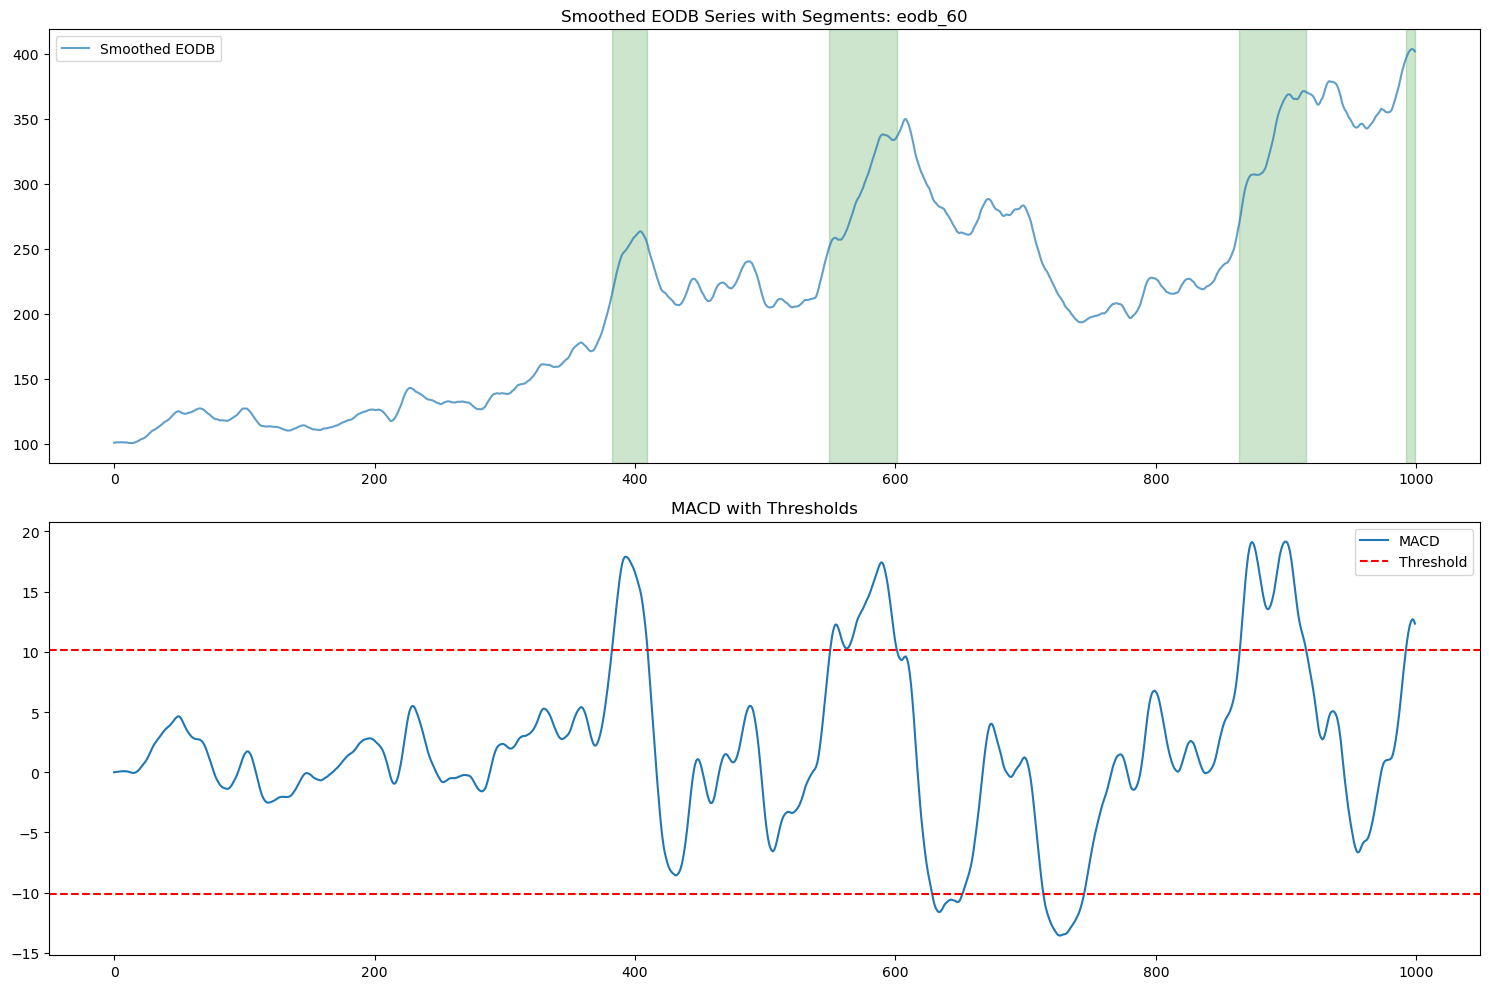

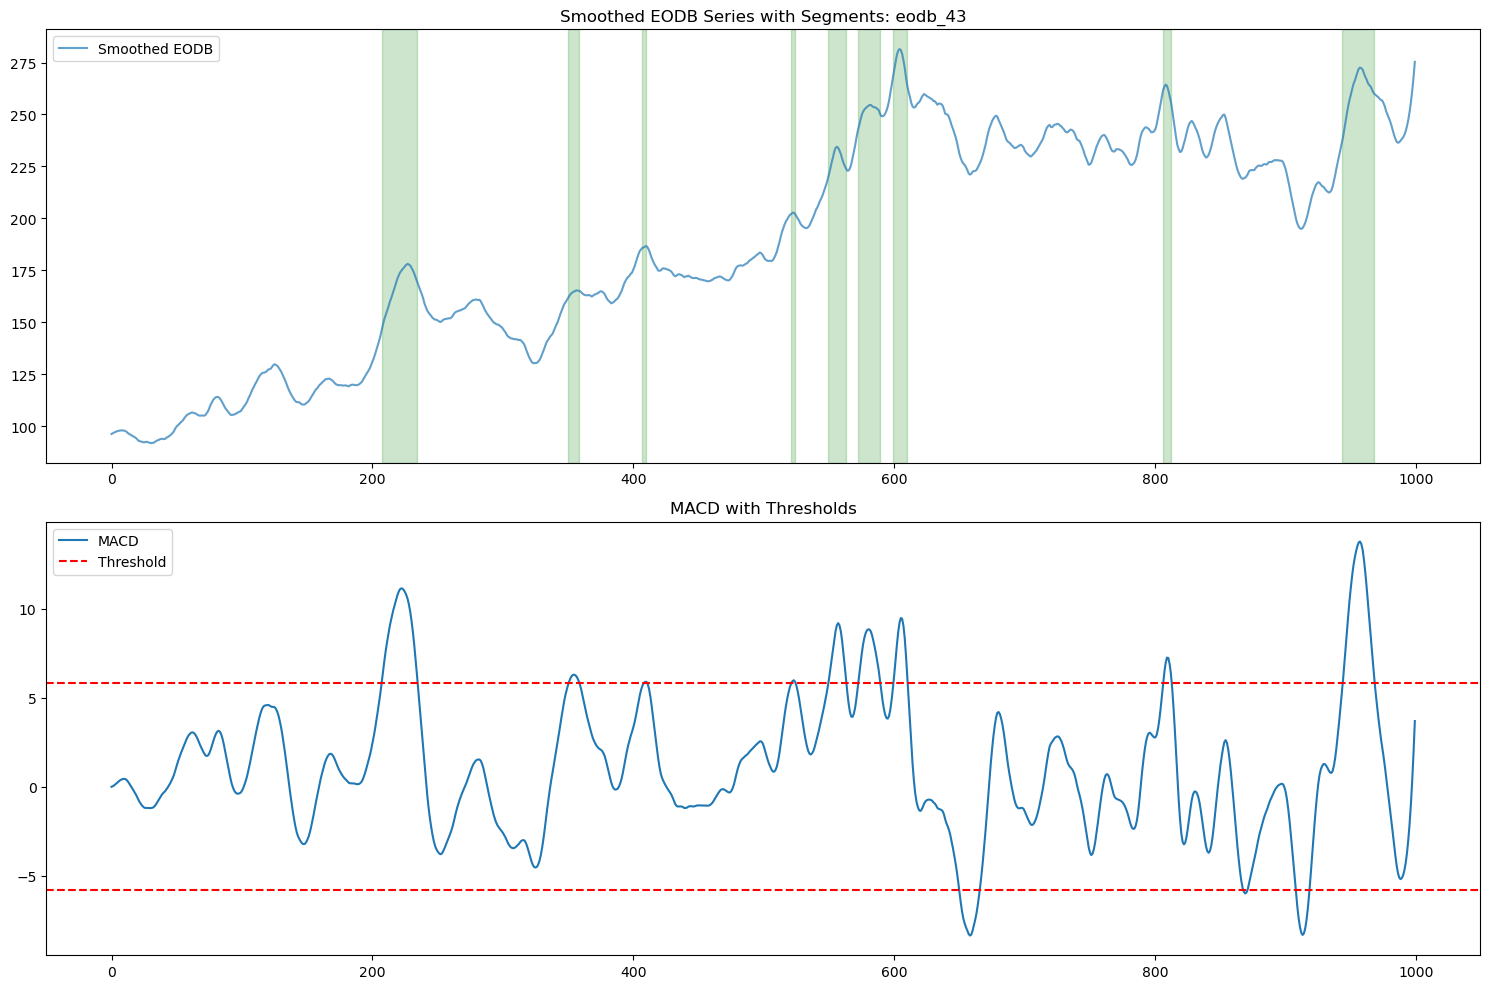

Processed 100 series
Results saved to data\segments\macd_segments.pkl


In [7]:
# Import cell
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from typing import Tuple, Dict
import random

# Configuration cell
INPUT_CONFIG = {
    'input_path': Path('data/eodb'),
    'input_filename': 'eodb_series.pkl',
    'output_path': Path('data/segments'),
    'output_filename': 'macd_segments.pkl',
    'savgol_window': 21,  # Must be odd
    'savgol_poly': 3,
    'macd_fast': 12,
    'macd_slow': 26,
    'macd_threshold': 1.5,
    'display_count': 5
}

# Functions cell
def smooth_series(series: np.ndarray) -> np.ndarray:
    """Apply Savitzky-Golay filter for smoothing"""
    return savgol_filter(series, 
                        window_length=INPUT_CONFIG['savgol_window'], 
                        polyorder=INPUT_CONFIG['savgol_poly'])

def calculate_macd(series: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Calculate MACD, signal line, and histogram"""
    fast_ema = pd.Series(series).ewm(span=INPUT_CONFIG['macd_fast'], 
                                    adjust=False).mean()
    slow_ema = pd.Series(series).ewm(span=INPUT_CONFIG['macd_slow'], 
                                    adjust=False).mean()
    macd_line = fast_ema - slow_ema
    return macd_line.values

def find_segments(series: np.ndarray, macd: np.ndarray) -> Dict:
    """Find segments based on MACD crossovers"""
    threshold = INPUT_CONFIG['macd_threshold'] * np.std(macd)
    above_threshold = macd > threshold
    transitions = np.diff(above_threshold.astype(int))
    
    segment_starts = np.where(transitions == 1)[0]
    segment_ends = np.where(transitions == -1)[0]
    
    # Handle edge cases
    if len(segment_ends) < len(segment_starts):
        segment_ends = np.append(segment_ends, len(macd)-1)
    if len(segment_starts) < len(segment_ends):
        segment_starts = np.insert(segment_starts, 0, 0)
    
    segments = {
        'series': series,
        'macd': macd,
        'starts': segment_starts,
        'ends': segment_ends
    }
    return segments

# Execution cell
# Load EODB data
input_file = INPUT_CONFIG['input_path'] / INPUT_CONFIG['input_filename']
eodb_df = pd.read_pickle(input_file)

# Process all series
segments_dict = {}
for column in eodb_df.columns:
    # Get original series
    series = eodb_df[column].values
    
    # Smooth the series
    smoothed = smooth_series(series)
    
    # Calculate MACD
    macd = calculate_macd(smoothed)
    
    # Find segments
    segments = find_segments(smoothed, macd)
    segments_dict[column] = segments

# Save results
INPUT_CONFIG['output_path'].mkdir(exist_ok=True, parents=True)
output_file = INPUT_CONFIG['output_path'] / INPUT_CONFIG['output_filename']
pd.to_pickle(segments_dict, output_file)

# Visualization cell
# Plot random samples
sample_series = random.sample(list(segments_dict.keys()), INPUT_CONFIG['display_count'])

for series_id in sample_series:
    segments = segments_dict[series_id]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot smoothed series with segments
    ax1.plot(segments['series'], label='Smoothed EODB', alpha=0.7)
    for start, end in zip(segments['starts'], segments['ends']):
        ax1.axvspan(start, end, alpha=0.2, color='green')
    ax1.set_title(f'Smoothed EODB Series with Segments: {series_id}')
    ax1.legend()
    
    # Plot MACD
    ax2.plot(segments['macd'], label='MACD')
    ax2.axhline(y=INPUT_CONFIG['macd_threshold'] * np.std(segments['macd']), 
                color='r', linestyle='--', label='Threshold')
    ax2.axhline(y=-INPUT_CONFIG['macd_threshold'] * np.std(segments['macd']), 
                color='r', linestyle='--')
    ax2.set_title('MACD with Thresholds')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

print(f"Processed {len(segments_dict)} series")
print(f"Results saved to {output_file}")
